In [265]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
#%matplotlib inline
%pylab inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

Populating the interactive namespace from numpy and matplotlib


In [266]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Ridge, Lasso  
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import scipy.stats as stats

## 1. Load in data and look for regression viability

In [267]:
# Load data 
docu = pd.read_csv('docu_clean.csv')
docu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 41 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   link_stub                               1969 non-null   object 
 1   rank                                    1969 non-null   object 
 2   title                                   1969 non-null   object 
 3   lifetime_gross                          1969 non-null   int64  
 4   max_theaters                            1969 non-null   float64
 5   opening                                 1969 non-null   float64
 6   open_th                                 1969 non-null   float64
 7   domestic_total_gross                    1969 non-null   int64  
 8   international_gross                     1969 non-null   int64  
 9   runtime                                 1969 non-null   float64
 10  Genres                                  1966 non-null   obje

In [268]:
docu.columns

Index(['link_stub', 'rank', 'title', 'lifetime_gross', 'max_theaters',
       'opening', 'open_th', 'domestic_total_gross', 'international_gross',
       'runtime', 'Genres', 'Director', 'Writers', 'Producers', 'wiki_url',
       'release_year', 'genres_listed', 'genres_listed_clean', 'biography',
       'history', 'music', 'drama', 'sport', 'comedy', 'crime', 'adventure',
       'war', 'distributor_Fathom Events', 'distributor_First Run',
       'distributor_IFC Films', 'distributor_Icarus Films',
       'distributor_International Film Circuit', 'distributor_Kino Lorber',
       'distributor_Magnolia Pictures', 'distributor_No Info',
       'distributor_Oscilloscope', 'distributor_Other',
       'distributor_Sony Pictures Classics', 'distributor_THINKFilm',
       'distributor_The Cinema Guild', 'distributor_Zeitgeist Films'],
      dtype='object')

Let's select all the numeric features as we won't be able to use the non-linear ones.

In [269]:
docum = docu[['lifetime_gross', 'max_theaters',
       'opening', 'open_th','domestic_total_gross',
       'international_gross', 'runtime', 'release_year', 
        'biography', 'history', 'music', 'drama',
       'sport', 'comedy', 'crime', 'adventure', 'war',
       'distributor_Fathom Events', 'distributor_First Run',
       'distributor_IFC Films', 'distributor_Icarus Films',
       'distributor_International Film Circuit', 'distributor_Kino Lorber',
       'distributor_Magnolia Pictures', 'distributor_No Info',
       'distributor_Oscilloscope', 'distributor_Other',
       'distributor_Sony Pictures Classics', 'distributor_THINKFilm',
       'distributor_The Cinema Guild', 'distributor_Zeitgeist Films']]

**Regression Viability**

Here we realize lifetime_gross and domestic_gross are the same, so let's drop the domestic_gross. 

In [270]:
del docum['domestic_total_gross']

Then with the correlation function we see that the dummy variables we carried from the data cleaning & feature engineering notebooks are not so well correlated with our targe, lifetime_gross. So we do a heatmap of the non engineered features. 

In [271]:
docum.corr()

,lifetime_gross,max_theaters,opening,open_th,international_gross,runtime,release_year,biography,history,music,...,distributor_International Film Circuit,distributor_Kino Lorber,distributor_Magnolia Pictures,distributor_No Info,distributor_Oscilloscope,distributor_Other,distributor_Sony Pictures Classics,distributor_THINKFilm,distributor_The Cinema Guild,distributor_Zeitgeist Films
lifetime_gross,1.000000,0.716290,0.784821,0.552774,0.768311,0.030045,-0.051431,-0.024302,-0.024899,0.051469,...,-0.018224,-0.030310,-0.007439,-0.028037,-0.020845,0.097091,0.017126,-0.001266,-0.021057,-0.023080
max_theaters,0.716290,1.000000,0.704376,0.830027,0.584185,0.029542,0.041096,-0.046929,-0.048447,0.081638,...,-0.030566,-0.044741,-0.021622,-0.026511,-0.026788,0.059334,0.002205,-0.015145,-0.033033,-0.040925
opening,0.784821,0.704376,1.000000,0.793394,0.700225,0.021947,-0.018851,-0.034118,-0.031632,0.095402,...,-0.013396,-0.013074,-0.017243,-0.014084,-0.015372,0.077054,-0.013162,-0.011761,-0.014333,-0.018399
open_th,0.552774,0.830027,0.793394,1.000000,0.535251,0.011878,-0.009891,-0.050051,-0.041526,0.105713,...,-0.019235,-0.018416,-0.024267,-0.003121,-0.022352,0.096281,-0.022019,-0.016009,-0.020464,-0.026895
international_gross,0.768311,0.584185,0.700225,0.535251,1.000000,0.032555,-0.038956,-0.032735,-0.028111,0.059599,...,-0.012236,-0.021752,-0.022184,-0.020476,-0.017568,0.080600,0.009903,-0.003951,-0.015041,-0.017918
runtime,0.030045,0.029542,0.021947,0.011878,0.032555,1.000000,-0.027097,0.025192,0.091016,0.032745,...,-0.030769,0.003817,0.023065,-0.003646,-0.053046,-0.043531,0.028243,0.017698,0.011402,-0.001842
release_year,-0.051431,0.041096,-0.018851,-0.009891,-0.038956,-0.027097,1.000000,0.015320,0.018403,-0.044805,...,-0.000861,0.117722,0.083300,-0.063226,0.080200,-0.150151,-0.051025,-0.105510,0.045384,-0.045463
biography,-0.024302,-0.046929,-0.034118,-0.050051,-0.032735,0.025192,0.015320,1.000000,0.162051,0.138452,...,-0.035724,0.018249,0.032093,-0.017552,-0.015445,-0.022978,0.057814,0.003988,-0.024122,0.016823
history,-0.024899,-0.048447,-0.031632,-0.041526,-0.028111,0.091016,0.018403,0.162051,1.000000,0.048214,...,0.051965,0.015172,-0.006199,-0.003617,-0.016600,-0.055717,0.059172,0.017308,-0.015971,-0.000164
music,0.051469,0.081638,0.095402,0.105713,0.059599,0.032745,-0.044805,0.138452,0.048214,1.000000,...,-0.012650,-0.010433,0.017345,-0.082375,-0.000694,0.041305,0.068663,0.011520,-0.048122,-0.020125


In [272]:
docum.head(3)

,lifetime_gross,max_theaters,opening,open_th,international_gross,runtime,release_year,biography,history,music,...,distributor_International Film Circuit,distributor_Kino Lorber,distributor_Magnolia Pictures,distributor_No Info,distributor_Oscilloscope,distributor_Other,distributor_Sony Pictures Classics,distributor_THINKFilm,distributor_The Cinema Guild,distributor_Zeitgeist Films
0,119194771,2011.0,23920637.0,868.0,103252111,122.0,2004,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,77437223,2506.0,137492.0,4.0,49955470,80.0,2005,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,73013910,3118.0,29514054.0,3105.0,26022917,105.0,2011,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [273]:
upper = np.triu(docum.iloc[:, :8].corr())  
upper

array([[ 1.        ,  0.71629048,  0.78482068,  0.55277441,  0.76831108,
         0.03004451, -0.05143093, -0.02430221],
       [ 0.        ,  1.        ,  0.70437588,  0.83002684,  0.58418524,
         0.02954249,  0.04109645, -0.04692872],
       [ 0.        ,  0.        ,  1.        ,  0.79339431,  0.70022476,
         0.02194673, -0.0188508 , -0.03411755],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.53525064,
         0.0118775 , -0.00989126, -0.05005135],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.03255486, -0.038956  , -0.03273472],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        , -0.0270966 ,  0.02519229],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.01531996],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ]])

Text(0.5, 1.0, 'Correlations between features')

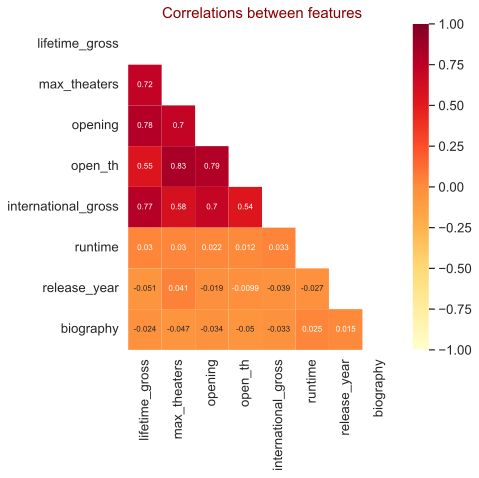

In [274]:
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(docum.iloc[:, :8].corr(), cmap="YlOrRd", annot=True, annot_kws={"size":8}, vmin=-1, vmax=1, mask=upper, ax=ax)
plt.title("Correlations between features", fontsize=15, color='darkred')

## 2. Baselining ##

### a. TARGET (Pre - Baselining): Log the large box office gross numbers

As we work on this problem, we realize that the gross needs to be logged in order for the numbers to be viable for linear regression. Let's also do the same for the international gross since it will have the same scale.

In [275]:
docum.columns

Index(['lifetime_gross', 'max_theaters', 'opening', 'open_th',
       'international_gross', 'runtime', 'release_year', 'biography',
       'history', 'music', 'drama', 'sport', 'comedy', 'crime', 'adventure',
       'war', 'distributor_Fathom Events', 'distributor_First Run',
       'distributor_IFC Films', 'distributor_Icarus Films',
       'distributor_International Film Circuit', 'distributor_Kino Lorber',
       'distributor_Magnolia Pictures', 'distributor_No Info',
       'distributor_Oscilloscope', 'distributor_Other',
       'distributor_Sony Pictures Classics', 'distributor_THINKFilm',
       'distributor_The Cinema Guild', 'distributor_Zeitgeist Films'],
      dtype='object')

In [276]:
docum['log_gross'] = docum['lifetime_gross'].apply(lambda x: np.log(x))

/var/folders/d4/30fcdv7d7gz0q0sc5sh4nd7c0000gp/T/ipykernel_88796/770025052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docum['log_gross'] = docum['lifetime_gross'].apply(lambda x: np.log(x))


In [277]:
del docum['lifetime_gross']

In [278]:
docum['log_int'] = docum['international_gross'].apply(lambda x: np.log(x))

/var/folders/d4/30fcdv7d7gz0q0sc5sh4nd7c0000gp/T/ipykernel_88796/1913245744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docum['log_int'] = docum['international_gross'].apply(lambda x: np.log(x))


In [279]:
del docum['international_gross']

### b. Hold out test data

In [280]:
X, y = docum.drop('log_gross',axis=1), docum['log_gross']

In [281]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=.25, random_state=4)

### c. Establish baseline

We'll just start with the first 6 features, the ones for which we have seen the correlations and then add the dummy variables/features to see if they help with our features

In [282]:
X_train_base = X_train.iloc[:, :6]

In [283]:
lm = LinearRegression()
lm.fit(X_train_base, y_train)

LinearRegression()

In [284]:
lm.score(X_val.iloc[:, :6], y_val)

0.32737393408745274

### d. Cross validation + Model choice

When we do our cross validation in model selection with the regular, lasso and ridge regressions, we see that ridge & regular regression are almost the same and way ahead of the lasso. We will go ahead with simple regression as it is actually the highest and lucky for us, the simple regression will make our coefficient and model interpretability a lot easier! 

In [285]:
#run the CV
X, y = np.array(X_train), np.array(y_train)
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm, cv_lm_ridge, cv_lm_lasso = [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    lm = LinearRegression()
    lm_lasso = Lasso()
    lm_ridge = Ridge(alpha=1)
    lm_poly = LinearRegression()

    #simple linear regression
    lm.fit(X_train, y_train)
    cv_lm.append(lm.score(X_val, y_val).round(3))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_ridge.fit(X_train_scaled, y_train)
    cv_lm_ridge.append(lm_ridge.score(X_val_scaled, y_val).round(3))
    
    #lasso with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_lasso.fit(X_train_scaled, y_train)
    cv_lm_lasso.append(lm_lasso.score(X_val_scaled, y_val).round(3))


print(f'Simple scores: \t{cv_lm}')
print(f'Ridge scores: \t{cv_lm_ridge}')
print(f'Lasso scores: \t{cv_lm_lasso} \n')

print(f'Simple mean cv r^2: {np.mean(cv_lm):.3f} +- {np.std(cv_lm):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_ridge):.3f} +- {np.std(cv_lm_ridge):.3f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso):.3f} +- {np.std(cv_lm_lasso):.3f}')


Simple scores: 	[0.777, 0.482, 0.732, 0.486, 0.614]
Ridge scores: 	[0.777, 0.484, 0.732, 0.492, 0.614]
Lasso scores: 	[0.339, 0.36, 0.327, 0.347, 0.344] 

Simple mean cv r^2: 0.618 +- 0.122
Ridge mean cv r^2: 0.620 +- 0.120
Lasso mean cv r^2: 0.343 +- 0.011


### e. Add engineered features: Dummies

Let's go back to the non-array way we had our train/val/test split set up.

In [286]:
X, y = docum.drop('log_gross',axis=1), docum['log_gross']

In [287]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=.25, random_state=4)

First let's add the genres and see how they improve our score. 
Then we'll add the distributors and see how they help. 

**i. Add genres**

In [288]:
X_2 = X_train.iloc[:, :14]
lm = LinearRegression()
lm.fit(X_2, y_train)
lm.score(X_val.iloc[:, :14], y_val)

0.35151416439135674

Yay, that did help! 

**ii. Add distributors**

In [289]:
X_3 = X_train
lm = LinearRegression()
lm.fit(X_3, y_train)
lm.score(X_val, y_val)

0.6322388398639947

And that too!

**iii.Lastly try some polynomial features to see if they bring up the score**

In [290]:
X_4 = X_train.copy()

In [291]:
X_4['max_th_sqr'] = X_4['max_theaters']**2

In [292]:
X4_train, X4_val, y4_train, y4_val = train_test_split(X_4, y_train, test_size=0.2, random_state=42)

In [293]:
lm = LinearRegression()
lm.fit(X4_train, y4_train)

LinearRegression()

In [294]:
val_score = lm.score(X4_val, y4_val)
print('Validation R^2 score was:', val_score)

Validation R^2 score was: 0.7448471514805771


Yay, that helped as well! 

In [295]:
print('Feature coefficient results: \n')
for feature, coef in zip(X4_train.columns, lm.coef_):
    print(feature, ':', f'{coef:.2f}') 

Feature coefficient results: 

max_theaters : 0.01
opening : 0.00
open_th : -0.00
runtime : 0.00
release_year : -0.03
biography : 0.24
history : 0.02
music : 0.16
drama : -0.06
sport : -0.05
comedy : -0.05
crime : 0.25
adventure : 0.02
war : 0.02
distributor_Fathom Events : -1.76
distributor_First Run : -0.70
distributor_IFC Films : 0.34
distributor_Icarus Films : -0.84
distributor_International Film Circuit : 0.39
distributor_Kino Lorber : -0.25
distributor_Magnolia Pictures : 0.57
distributor_No Info : -0.25
distributor_Oscilloscope : 0.35
distributor_Other : -0.12
distributor_Sony Pictures Classics : 1.14
distributor_THINKFilm : -0.14
distributor_The Cinema Guild : -0.85
distributor_Zeitgeist Films : 0.56
log_int : 0.53
max_th_sqr : -0.00


### f. Plot to see what is going on

Alright, we came a long way. Let's see what is going on with some diagnostic plots and try and interpret them. 

In [296]:
preds = lm.predict(X4_val)

[Text(0.5, 0, 'Predictions'),
 Text(0, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Predicted vs. Actual Gross')]

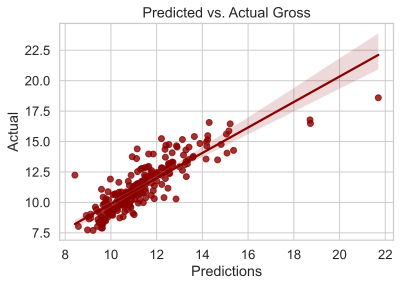

In [297]:
fig = sns.regplot(x=preds,y=y4_val, color = 'darkred')
fig.set(xlabel='Predictions',ylabel = 'Actual', title = 'Predicted vs. Actual Gross')

In [298]:
def diagnostic_plot(x, y, title = ''):
    plt.figure(figsize=(10,4))

    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.suptitle(title, y=1.05, fontsize=15, color='darkred')
    
    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='darkred',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
    plt.tight_layout()

In [299]:
X_arr, y_arr = np.array(X_train), np.array(y_train)

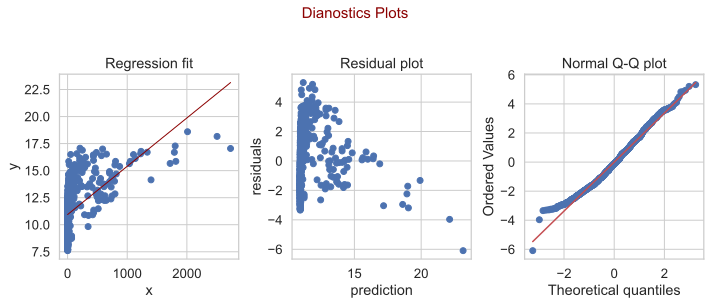

In [300]:
plt.rc('font', size=10)  
diagnostic_plot(X_arr[:, 0].reshape(-1,1), y_arr, "Dianostics Plots") 

The residuals should really be around 0 but definitely are not. Especially in the lower end. It seems that our model is not as predictive in the lower 'grossing' amounts but becomes more accurate once the gross becomes higher. This makes sense to me, especially with the genre we have chosen: documentary. Most documentaries are not necessarily high budget movies (at least for the most part) and there is a lot of different factors for gross income success at the lower end of the spectrum. But the higher the gross becomes, we have less movies to look at and the predictability goes up higher. 

## 3. Scoring 

### a. Score on hold out set

Before we score, we have to apply the extra feature transformations to the test set as well. 

In [301]:
X_test['max_th_sqr'] = X_test['max_theaters']**2

/var/folders/d4/30fcdv7d7gz0q0sc5sh4nd7c0000gp/T/ipykernel_88796/3335704971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['max_th_sqr'] = X_test['max_theaters']**2


In [302]:
lm.score(X_test, y_test)

0.6510649500081314

OK, there is a bit of overfitting here. Our validation score was 0.74 and we went down to 0.65. Going back, we could see about ridge again to combat the complexity and the overfitting problem.

### b. Get intercept & coefficients

In [303]:
print(lm.intercept_)
print(lm.coef_)

59.278517272762166
[ 6.65479984e-03  1.01925943e-07 -1.48859825e-03  8.17174500e-04
 -2.69160220e-02  2.40159012e-01  1.94134998e-02  1.59718922e-01
 -5.75187180e-02 -4.88316228e-02 -5.12745072e-02  2.49433853e-01
  1.94727997e-02  1.71785940e-02 -1.76319824e+00 -7.03707124e-01
  3.42182590e-01 -8.42394855e-01  3.88762802e-01 -2.48026451e-01
  5.68904882e-01 -2.51153183e-01  3.52273127e-01 -1.17303575e-01
  1.13695604e+00 -1.41838747e-01 -8.53490861e-01  5.61614381e-01
  5.28249116e-01 -1.94393199e-06]


In [304]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_test.columns, lm.coef_):
    print(feature, ':', f'{coef:.2f}') 

Feature coefficient results: 

max_theaters : 0.01
opening : 0.00
open_th : -0.00
runtime : 0.00
release_year : -0.03
biography : 0.24
history : 0.02
music : 0.16
drama : -0.06
sport : -0.05
comedy : -0.05
crime : 0.25
adventure : 0.02
war : 0.02
distributor_Fathom Events : -1.76
distributor_First Run : -0.70
distributor_IFC Films : 0.34
distributor_Icarus Films : -0.84
distributor_International Film Circuit : 0.39
distributor_Kino Lorber : -0.25
distributor_Magnolia Pictures : 0.57
distributor_No Info : -0.25
distributor_Oscilloscope : 0.35
distributor_Other : -0.12
distributor_Sony Pictures Classics : 1.14
distributor_THINKFilm : -0.14
distributor_The Cinema Guild : -0.85
distributor_Zeitgeist Films : 0.56
log_int : 0.53
max_th_sqr : -0.00


### c. Lastly, let's get some error metrics

In [305]:
preds = lm.predict(X_test)

In [306]:
rmse = mean_squared_error(y_test, preds, squared=False)
print(rmse)

1.1874730365377912


In [307]:
mae = mean_absolute_error(y_test, preds)
print(mae)

0.8622151713266151
